# Using the 20 "best" SA models, explore the variability in melt data that we generated


In [1]:
from __future__ import print_function
%pylab notebook
# import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as md
#from nose.tools import set_trace
from charistools.hypsometry import Hypsometry
from charistools.meltModels import CalibrationCost
from charistools.modelEnv import ModelEnv
import pandas as pd
import re
import os

Populating the interactive namespace from numpy and matplotlib


In [5]:
%cd ~/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad
%ls *snow_on_land*

/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad
AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2003.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2004.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2005.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2006.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2007.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt
AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.sno

In [80]:
def get_ddfs_and_surface(hyps):
    '''
    Gets the min/max ddfs from the hyps.comments
    Returns a tuple with min, max
    '''
    min_ddf = np.nan
    max_ddf = np.nan
    surface = "unknown"
    pmin = re.compile(r"min_DDF_mm_pday_pdegC") 
    pmax = re.compile(r"max_DDF_mm_pday_pdegC")  
    psurface = re.compile(r"melt for")
    for line in hyps.comments:
        if pmin.search(line):
            key, value = line.split(" : ")
            min_ddf = float(value)
        if pmax.search(line):
            key, value = line.split(" : ")
            max_ddf = float(value)
        if psurface.search(line):
            surface, dummy = psurface.split(line)
            surface = surface[1:].lstrip().rstrip()
            surface = surface.replace(" ", "_")

    return (min_ddf, max_ddf, surface)

In [174]:
drainageIDs = ["IN_Hunza_at_DainyorBridge", 
               "AM_Vakhsh_at_Komsomolabad", 
               "SY_Naryn_at_NarynTown", 
               "GA_SaptaKosi_at_Chatara",
               "GA_Karnali_at_Benighat"]

dir = "/Users/brodzik/projects/CHARIS/derived_hypsometries"
for drainageID in drainageIDs:
    df = pd.DataFrame([])
    for cycle in np.arange(20) + 81:
        for year in np.arange(14) + 2001:
        
            # Get a list of melt filenames for this drainageID, cycle and year
            # There will be three, one for each surface type
            list = sort(glob.glob("%s/REECv0_Cycle%03d/%s/*%d*" % (dir, cycle, drainageID, year)))
            print(cycle, year)
            print(list)
            row = {"cycle":cycle,
                   "drainageID":drainageID}
            for f in list:
                hyps = Hypsometry(f)
                total_melt_km3 = hyps.data.sum().sum()
                min_ddf, max_ddf, surface = get_ddfs_and_surface(hyps)
                row["year"] = hyps.data.index[0].year
                row["%s_min_ddf" % (surface)] = min_ddf
                row["%s_max_ddf" % (surface)] = max_ddf
                row["%s_melt_km3" % (surface)] = total_melt_km3
            
            result = pd.DataFrame.from_dict(row, orient='index').transpose()
        
            result = result[["year", "cycle", "drainageID", 
                             "Snow_on_land_min_ddf", "Snow_on_land_max_ddf", "Snow_on_land_melt_km3",
                             "Snow_on_ice_min_ddf", "Snow_on_ice_max_ddf", "Snow_on_ice_melt_km3",
                             "Exposed_glacier_ice_min_ddf", "Exposed_glacier_ice_max_ddf", "Exposed_glacier_ice_melt_km3"]]
        
            df = df.append(result)
    
    outfile = "%s/REECv0_CycleSummary/%s.annual_melt.last20.dat" % (dir, drainageID)
    print("Output to: %s" % outfile, file=sys.stderr)
    df.to_pickle(outfile)
                         


81 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
81 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/I

81 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
82 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/IN_Hunza_at_DainyorBridge/I

82 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
82 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/IN_Hunza_at_DainyorBridge/I

83 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
83 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/IN_Hunza_at_DainyorBridge/I

84 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
84 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/IN_Hunza_at_DainyorBridge/I

85 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
85 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/IN_Hunza_at_DainyorBridge/I

86 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
86 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/IN_Hunza_at_DainyorBridge/I

87 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
87 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/IN_Hunza_at_DainyorBridge/I

88 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2007.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
88 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/IN_Hunza_at_DainyorBridge/I

89 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2006.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
89 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/IN_Hunza_at_DainyorBridge/I

90 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2005.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
90 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/IN_Hunza_at_DainyorBridge/I

91 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2004.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
91 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/IN_Hunza_at_DainyorBridge/I

92 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2003.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
92 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/IN_Hunza_at_DainyorBridge/I

93 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2002.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
93 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/IN_Hunza_at_DainyorBridge/I

94 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
94 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/I

94 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
95 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/IN_Hunza_at_DainyorBridge/I

95 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
95 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/IN_Hunza_at_DainyorBridge/I

96 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
96 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/IN_Hunza_at_DainyorBridge/I

97 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
97 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/IN_Hunza_at_DainyorBridge/I

98 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
98 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/IN_Hunza_at_DainyorBridge/I

99 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
99 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/IN_Hunza_at_DainyorBridge/I

100 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Hunza_SA_model.txt']
100 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Hunza_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/IN_Hunza_at_DainyorBridge

Output to: /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/IN_Hunza_at_DainyorBridge.annual_melt.last20.dat


81 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
81 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolab

81 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
82 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/AM_Vakhsh_at_Komsomolab

82 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
82 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/AM_Vakhsh_at_Komsomolab

83 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
83 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/AM_Vakhsh_at_Komsomolab

84 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
84 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/AM_Vakhsh_at_Komsomolab

85 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
85 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/AM_Vakhsh_at_Komsomolab

86 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
86 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/AM_Vakhsh_at_Komsomolab

87 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
87 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/AM_Vakhsh_at_Komsomolab

88 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2007.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
88 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/AM_Vakhsh_at_Komsomolab

89 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2006.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
89 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/AM_Vakhsh_at_Komsomolab

90 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2005.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
90 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/AM_Vakhsh_at_Komsomolab

91 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2004.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
91 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/AM_Vakhsh_at_Komsomolab

92 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2003.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
92 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/AM_Vakhsh_at_Komsomolab

93 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
93 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/AM_Vakhsh_at_Komsomolab

94 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
94 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolab

94 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
95 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/AM_Vakhsh_at_Komsomolab

95 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
95 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/AM_Vakhsh_at_Komsomolab

96 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
96 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/AM_Vakhsh_at_Komsomolab

97 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
97 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/AM_Vakhsh_at_Komsomolab

98 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
98 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/AM_Vakhsh_at_Komsomolab

99 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
99 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/AM_Vakhsh_at_Komsomolab

100 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Vakhsh_SA_model.txt']
100 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Vakhsh_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/AM_Vakhsh_at_Komsomol

Output to: /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/AM_Vakhsh_at_Komsomolabad.annual_melt.last20.dat


81 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
81 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modi

82 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
82 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modi

83 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
83 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modi

84 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
84 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modi

85 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
85 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modi

85 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
86 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

86 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
87 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

87 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
88 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

88 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
89 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

89 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
90 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

90 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
91 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

91 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
92 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

92 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
93 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

93 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
94 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modi

94 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
94 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modi

95 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
95 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modi

96 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
96 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modi

97 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
97 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modi

98 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
98 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modi

99 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
99 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modi

100 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Naryn_SA_model.txt']
100 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Naryn_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.mo

Output to: /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/SY_Naryn_at_NarynTown.annual_melt.last20.dat


81 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
81 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_

81 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
82 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_SaptaKosi_at_Chatara/GA_

82 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
82 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_SaptaKosi_at_Chatara/GA_

83 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
83 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_SaptaKosi_at_Chatara/GA_

84 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
84 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_SaptaKosi_at_Chatara/GA_

85 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
85 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_SaptaKosi_at_Chatara/GA_

86 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
86 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_SaptaKosi_at_Chatara/GA_

87 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
87 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_SaptaKosi_at_Chatara/GA_

88 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2007.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
88 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_SaptaKosi_at_Chatara/GA_

89 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2006.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
89 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_SaptaKosi_at_Chatara/GA_

90 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2005.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
90 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_SaptaKosi_at_Chatara/GA_

91 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2004.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
91 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_SaptaKosi_at_Chatara/GA_

92 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2003.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
92 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_SaptaKosi_at_Chatara/GA_

93 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2002.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
93 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_SaptaKosi_at_Chatara/GA_

94 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
94 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_

94 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
95 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_SaptaKosi_at_Chatara/GA_

95 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
95 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_SaptaKosi_at_Chatara/GA_

96 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
96 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_SaptaKosi_at_Chatara/GA_

97 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
97 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_SaptaKosi_at_Chatara/GA_

98 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
98 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_SaptaKosi_at_Chatara/GA_

99 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
99 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_SaptaKosi_at_Chatara/GA_

100 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_SaptaKosi_SA_model.txt']
100 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_SaptaKosi_at_Chatara/GA_SaptaKosi_at_Chatara.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_SaptaKosi_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_SaptaKosi_at_Chatara/G

Output to: /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_SaptaKosi_at_Chatara.annual_melt.last20.dat


81 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
81 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

81 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle081/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
82 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

82 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
82 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle082/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

83 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
83 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle083/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

84 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
84 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle084/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

85 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
85 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle085/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

86 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
86 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle086/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

87 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
87 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle087/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

88 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2007.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
88 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle088/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

89 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2006.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
89 2007
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2007.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle089/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

90 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2005.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
90 2006
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2006.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle090/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

91 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2004.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
91 2005
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2005.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle091/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

92 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2003.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
92 2004
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2004.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle092/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

93 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2002.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
93 2003
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2003.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle093/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

94 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
94 2002
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2002.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

94 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle094/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
95 2001
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2001.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

95 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
95 2014
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2014.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle095/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

96 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
96 2013
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2013.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle096/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

97 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
97 2012
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2012.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle097/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

98 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
98 2011
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2011.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle098/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

99 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
99 2010
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2010.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle099/GA_Karnali_at_Benighat/GA_Karnali_at_Benigh

100 2008
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2008.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.snow_on_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2008.0100m.modicev04_2strike.snow_on_land_melt_by_elev.best_Karnali_SA_model.txt']
100 2009
[ '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_Karnali_at_Benighat/GA_Karnali_at_Benighat.2009.0100m.modicev04_2strike.GRSIZE_SCAG.fromFile.exposed_glacier_ice_melt_by_elev.best_Karnali_SA_model.txt'
 '/Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_Cycle100/GA_Karnali_at_Benighat/GA_Karnali_at_Beni

Output to: /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_Karnali_at_Benighat.annual_melt.last20.dat


last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/IN_Hunza_at_DainyorBridge.annual_melt.last20.dat


<IPython.core.display.Javascript object>


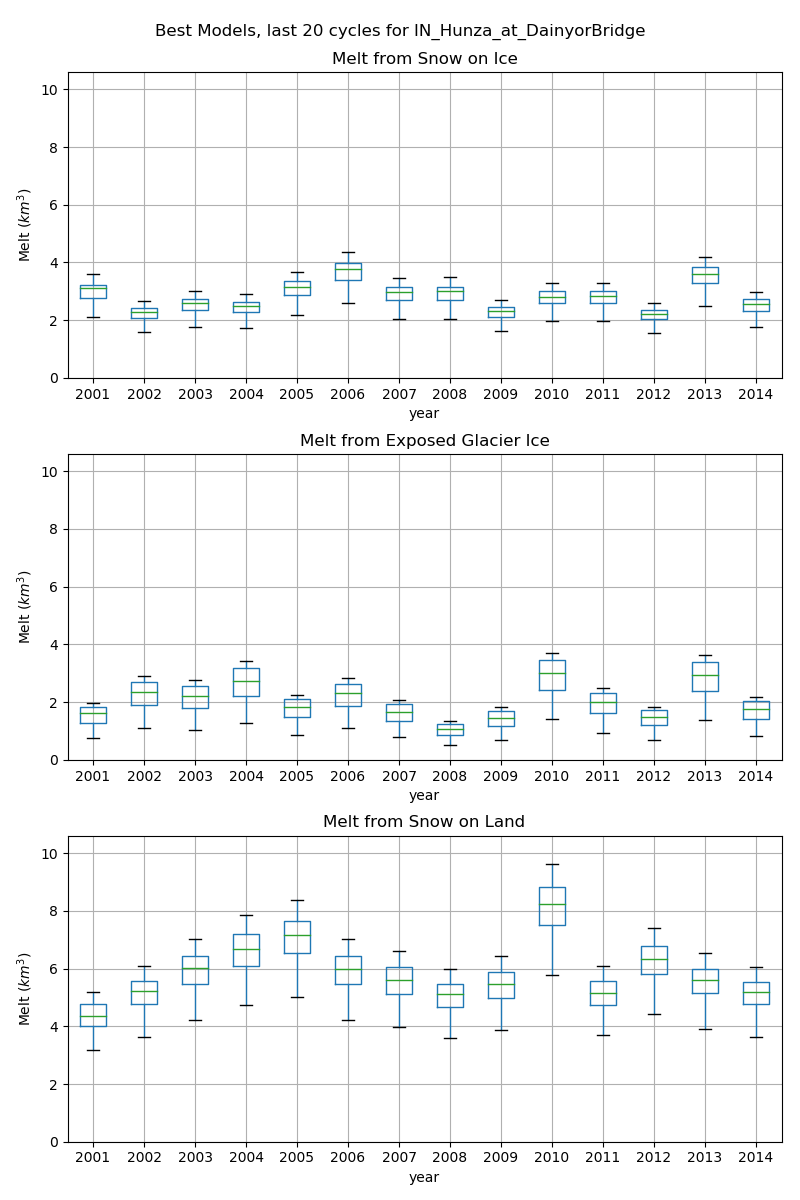

Saving plot to /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/IN_Hunza_at_DainyorBridge.annual_melt.last20.dat.png


last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/AM_Vakhsh_at_Komsomolabad.annual_melt.last20.dat


<IPython.core.display.Javascript object>


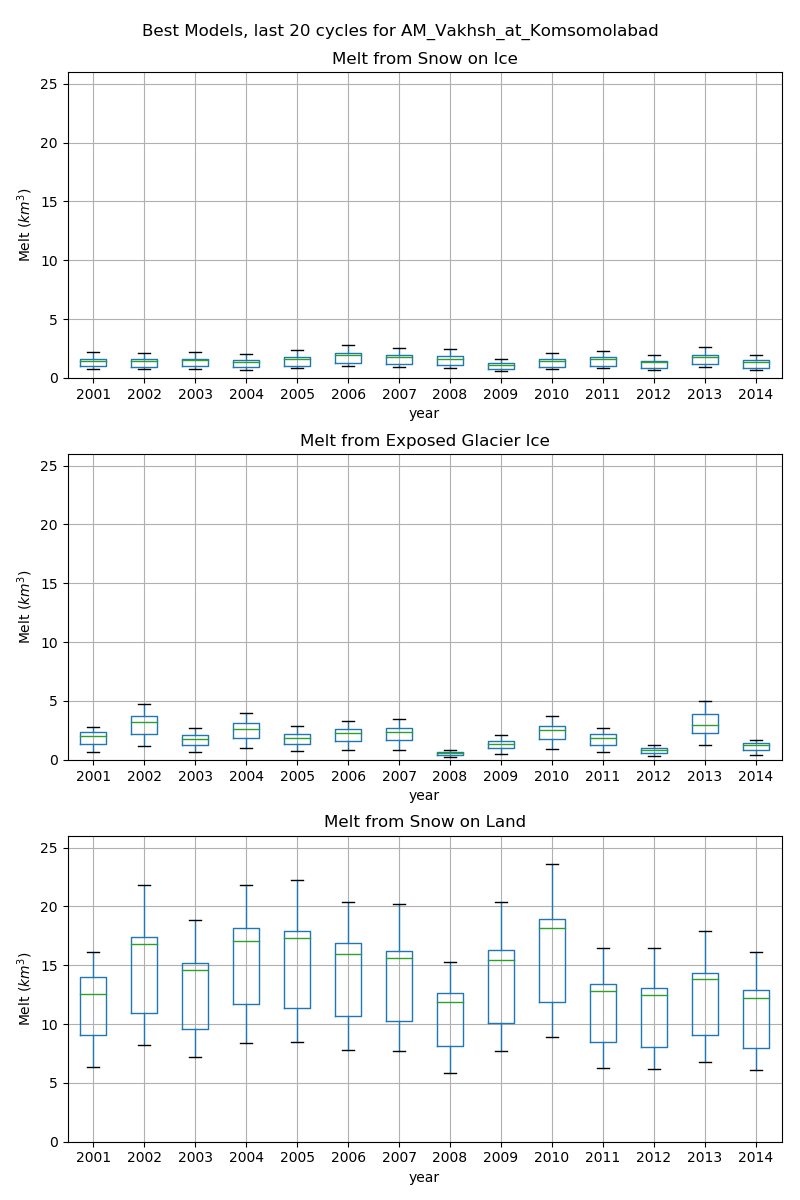

Saving plot to /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/AM_Vakhsh_at_Komsomolabad.annual_melt.last20.dat.png


last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/SY_Naryn_at_NarynTown.annual_melt.last20.dat


<IPython.core.display.Javascript object>


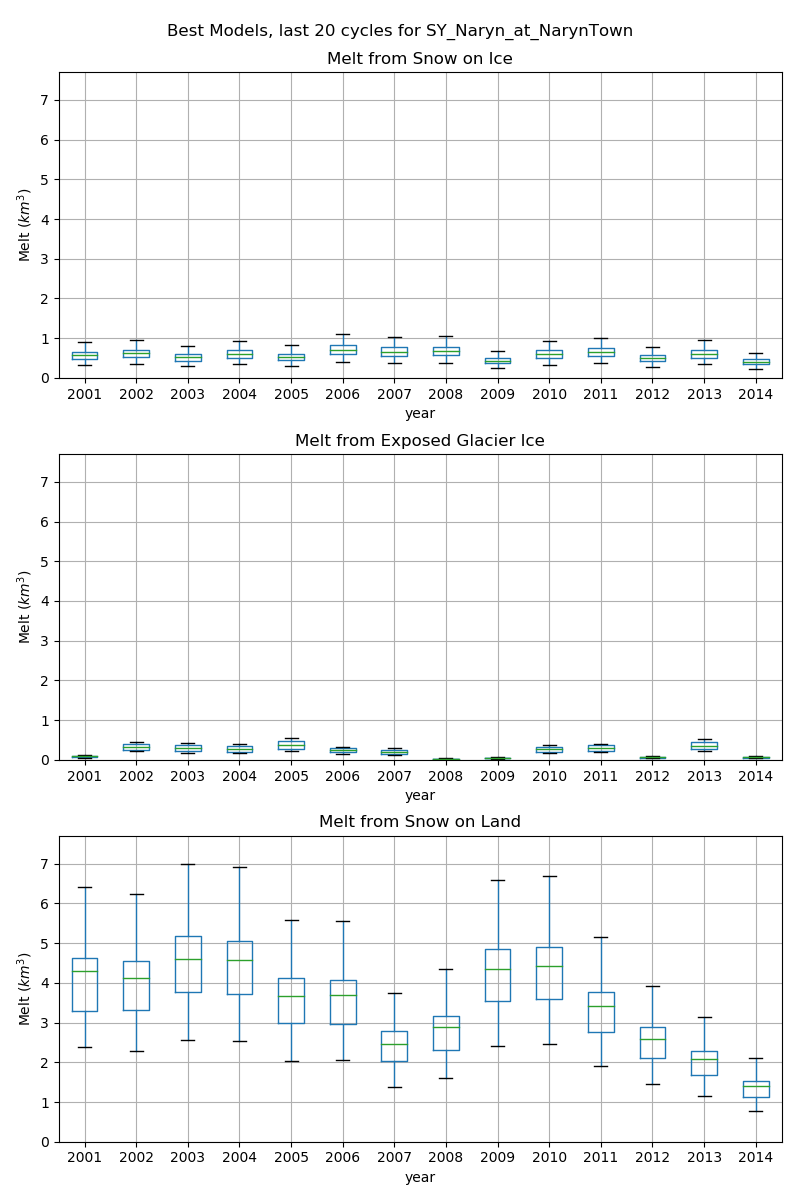

Saving plot to /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/SY_Naryn_at_NarynTown.annual_melt.last20.dat.png


last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_SaptaKosi_at_Chatara.annual_melt.last20.dat


<IPython.core.display.Javascript object>


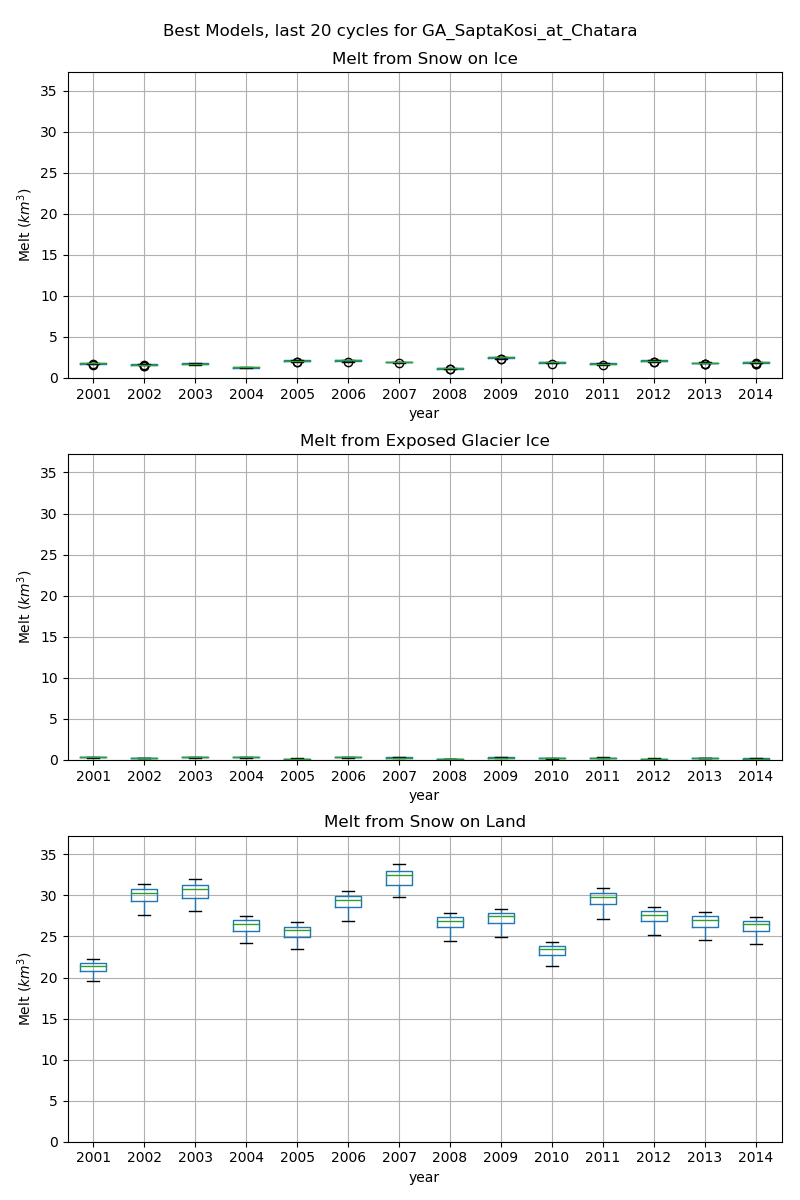

Saving plot to /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_SaptaKosi_at_Chatara.annual_melt.last20.dat.png


last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_Karnali_at_Benighat.annual_melt.last20.dat


<IPython.core.display.Javascript object>


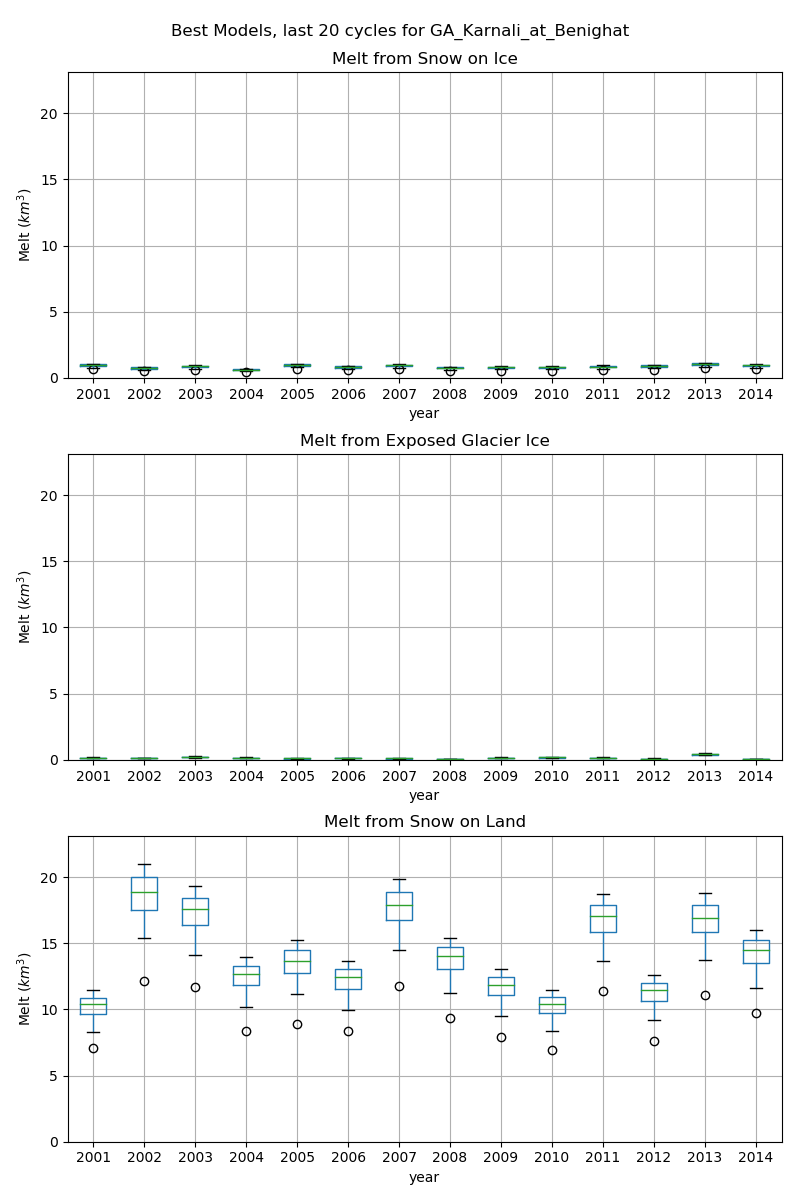

Saving plot to /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_Karnali_at_Benighat.annual_melt.last20.dat.png


In [191]:
for drainageID in drainageIDs:
    file = "%s/REECv0_CycleSummary/%s.annual_melt.last20.dat" % (dir, drainageID)
    print("last20 file %s" % file, file=sys.stderr)
    df = pd.read_pickle(file)

    melt = df.copy()
    melt.drop(['Snow_on_land_min_ddf','Snow_on_land_max_ddf',
               'Snow_on_ice_min_ddf','Snow_on_ice_max_ddf',
               'Exposed_glacier_ice_min_ddf','Exposed_glacier_ice_max_ddf'], axis=1, inplace=True)

    fig, axes = plt.subplots(3, 1, figsize=(8,12))

    melt.boxplot(ax=axes[0],
                 column='Snow_on_ice_melt_km3',
                 by='year')
    axes[0].set_title("Melt from Snow on Ice")

    melt.boxplot(ax=axes[1],
                 column='Exposed_glacier_ice_melt_km3', 
                 by='year')
    axes[1].set_title("Melt from Exposed Glacier Ice")

    melt.boxplot(ax=axes[2],
                 column='Snow_on_land_melt_km3',
                 by='year')
    axes[2].set_title("Melt from Snow on Land")

    for ax in axes:
        ax.set_ylim([0., 
                     1.1 * melt[['Snow_on_land_melt_km3', 'Snow_on_ice_melt_km3', 'Exposed_glacier_ice_melt_km3']].max().max()])
        ax.set_ylabel('Melt ($km^3$)')

    fig.suptitle("Best Models, last 20 cycles for %s" % drainageID)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    outfile = "%s.png" % file
    plt.savefig(outfile)
    print("Saving plot to %s" % outfile)

# Make a plot of overal variability by basin and surface type

In [192]:
dir = "/Users/brodzik/projects/CHARIS/derived_hypsometries"
drainageIDs = ["IN_Hunza_at_DainyorBridge", 
               "AM_Vakhsh_at_Komsomolabad", 
               "SY_Naryn_at_NarynTown", 
               "GA_SaptaKosi_at_Chatara",
               "GA_Karnali_at_Benighat"]alldf = pd.DataFrame([])

for drainageID in drainageIDs:
    file = "%s/REECv0_CycleSummary/%s.annual_melt.last20.dat" % (dir, drainageID)
    print("last20 file %s" % file, file=sys.stderr)
    df = pd.read_pickle(file)

    melt = df.copy()
    melt.drop(['Snow_on_land_min_ddf','Snow_on_land_max_ddf',
               'Snow_on_ice_min_ddf','Snow_on_ice_max_ddf',
               'Exposed_glacier_ice_min_ddf','Exposed_glacier_ice_max_ddf'], axis=1, inplace=True)
    alldf = alldf.append(melt)

last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/IN_Hunza_at_DainyorBridge.annual_melt.last20.dat
last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/AM_Vakhsh_at_Komsomolabad.annual_melt.last20.dat
last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/SY_Naryn_at_NarynTown.annual_melt.last20.dat
last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_SaptaKosi_at_Chatara.annual_melt.last20.dat
last20 file /Users/brodzik/projects/CHARIS/derived_hypsometries/REECv0_CycleSummary/GA_Karnali_at_Benighat.annual_melt.last20.dat


In [197]:
alldf


,year,cycle,drainageID,Snow_on_land_melt_km3,Snow_on_ice_melt_km3,Exposed_glacier_ice_melt_km3
0,2001,81,IN_Hunza_at_DainyorBridge,4.73781,3.23292,1.02815
0,2002,81,IN_Hunza_at_DainyorBridge,5.55936,2.41648,1.50101
0,2003,81,IN_Hunza_at_DainyorBridge,6.40275,2.72246,1.41404
0,2004,81,IN_Hunza_at_DainyorBridge,7.15542,2.63651,1.75849
0,2005,81,IN_Hunza_at_DainyorBridge,7.61826,3.35335,1.16513
0,2006,81,IN_Hunza_at_DainyorBridge,6.39642,3.96588,1.47209
0,2007,81,IN_Hunza_at_DainyorBridge,6.01718,3.14399,1.0647
0,2008,81,IN_Hunza_at_DainyorBridge,5.45505,3.14092,0.693564
0,2009,81,IN_Hunza_at_DainyorBridge,5.84548,2.45103,0.93484
0,2010,81,IN_Hunza_at_DainyorBridge,8.77636,2.99441,1.92863


<IPython.core.display.Javascript object>


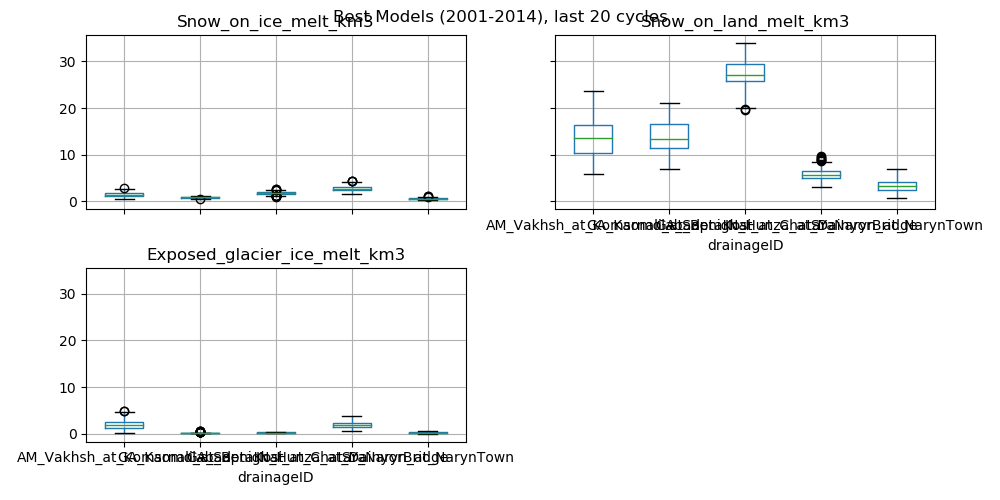

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

alldf.boxplot(ax=ax,
              column=['Snow_on_ice_melt_km3','Snow_on_land_melt_km3','Exposed_glacier_ice_melt_km3'],
              by='drainageID')
ax.set_title("Melt Title")

    #ax.set_ylim([0., 
    #                 1.1 * melt[['Snow_on_land_melt_km3', 'Snow_on_ice_melt_km3', 'Exposed_glacier_ice_melt_km3']].max().max()])
ax.set_ylabel('Melt ($km^3$)')

fig.suptitle("Best Models (2001-2014), last 20 cycles")
fig.tight_layout()


In [73]:
surf = surf.replace(" ", "_")
surf

'Snow_on_land'

In [ ]:
def find_ddf_variation(drainageID, nstrikes=3):
    
    # Read SA summary file, this is DDFs and z at end of each cycle
    dir = "/work/charis/ti_model/calibrations_correct_cost"
    params = "DDFnbr=10mm_N100_M050"
    list = glob.glob("%s/%s.%dstr_%s.SA_summary.dat" % (
        dir, drainageID, nstrikes, params))
    if 1 != len(list):
        print("Error looking for SA_summary file for %s" % drainageID, file=sys.stderr)
    SAFile = list[0]
    print("SA_summary file : %s" % SAFile, file=sys.stderr)
    SAdf = pd.read_pickle(SAFile)
    
    # Drop first 61 rows of SA output, to limit analysis to stable stuff at end
    num_cycles_to_drop = 61
    stabledf = SAdf.drop(SAdf.index[np.arange(num_cycles_to_drop)])
    summarydf = stabledf.describe()
    
    # Read all calibration stats output and parse best model parameters from it
    list = glob.glob("%s/%s.%dstr_%s.z*Best*stats.png" % (
        dir, drainageID, nstrikes, params))
    if 1 != len(list):
        print("Error looking for stats file for %s" % drainageID, file=sys.stderr)
    statsFile = list[0]
    print("stats file : %s" % statsFile, file=sys.stderr)
    
    best = np.zeros(4)
    best_low = np.zeros(4)
    best_high = np.zeros(4)
    
    # Parse the best model ddfs from the filename
    p = re.compile(r'Best(\d+\.\d+)_(\d+\.\d+)_(\d+\.\d+)_(\d+\.\d+)')
    m = p.search(statsFile)
    for i in np.arange(4):
        best[i] = float(m.group(i+1))
    
    # Use the variation from the stable cycles to calculate best_minus1std and best_plus1std
    best_low = best.copy()
    best_high = best.copy()
    
    ddf = ['winter_snow_ddf', 'summer_snow_ddf', 'winter_ice_ddf', 'summer_ice_ddf']
    for i in np.arange(len(ddf)):
        best_low[i] = best_low[i] - summarydf.loc['std', ddf[i]]
        best_high[i] = best_high[i] + summarydf.loc['std', ddf[i]]
        
    # Do QC to ensure that each range enforces low <= high
    if best_low[0] > best_low[1]:
        print("Warning: QC problem on low snow DDFs, forcing them to lower value")
        best_low[0] = best_low[1]
    if best_low[2] > best_low[3]:
        print("Warning: QC problem on low ice DDFs, forcing them to lower value")
        best_low[2] = best_low[3]
        
    if best_high[0] > best_high[1]:
        print("Warning: QC problem on high snow DDFs, forcing them to higher value")
        best_high[1] = best_high[0]
    if best_high[2] > best_high[3]:
        print("Warning: QC problem on high ice DDFs, forcing them to higher value")
        best_high[3] = best_high[2]
    
    # Make model strings and return them
    best_str = "_".join(["%.2f" % i for i in best])
    best_low_str = "_".join(["%.2f" % i for i in best_low])
    best_high_str = "_".join(["%.2f" % i for i in best_high])
    
    result = {'drainageID': drainageID,
              'nstrikes': nstrikes,
              'Best': best_str, 
              'High': best_high_str,
              'Low': best_low_str}
    
    result = pd.DataFrame.from_dict(result, orient='index').transpose()
    result.set_index('drainageID', inplace=True)
    result = result[['nstrikes', 'Low', 'Best', 'High']]
    
    return result

In [ ]:
drainageID = "GA_Karnali_at_Benighat"
result = find_ddf_variation(drainageID, nstrikes=2)

In [ ]:
drainageIDs = ['SY_Naryn_at_NarynTown',
               'AM_Vakhsh_at_Komsomolabad',
               'IN_Hunza_at_DainyorBridge',
               'GA_Karnali_at_Benighat',
               'GA_Narayani_at_Devghat',
               'GA_SaptaKosi_at_Chatara']
strikes = [2, 3]
df = pd.DataFrame([])
for drainageID in drainageIDs:
    for strike in strikes:
        result = find_ddf_variation(drainageID, nstrikes=strike)
        df = df.append(result)

In [ ]:
#drainageID = "GA_Karnali_at_Benighat"
#nstrikes = 2
def best_models(drainageID, nstrikes=3):
    # Read SA summary file, this is DDFs and z at end of each cycle
    dir = "/work/charis/ti_model/calibrations_correct_cost"
    params = "DDFnbr=10mm_N100_M050"
    list = glob.glob("%s/%s.%dstr_%s.SA_summary.dat" % (
        dir, drainageID, nstrikes, params))
    if 1 != len(list):
        print("Error looking for SA_summary file for %s" % drainageID, file=sys.stderr)
    SAFile = list[0]
    print("SA_summary file : %s" % SAFile, file=sys.stderr)
    df = pd.read_pickle(SAFile)
    
    df.loc[:, "model"] = (
        df["winter_snow_ddf"].map(str) + "_" +
        df["summer_snow_ddf"].map(str) + "_" +
        df["winter_ice_ddf"].map(str) + "_" +
        df["summer_ice_ddf"].map(str))

    df["nstrikes"] = nstrikes

    outfile = "%s/%s.%dstr_%s.SA_summary.best20.dat" % (
        dir, drainageID, nstrikes, params)

    df.to_pickle(outfile)
    print("outfile: %s" % outfile, file=sys.stderr)

In [ ]:
drainageIDs = ['SY_Naryn_at_NarynTown',
               'AM_Vakhsh_at_Komsomolabad',
               'IN_Hunza_at_DainyorBridge',
               'GA_Karnali_at_Benighat',
               'GA_Narayani_at_Devghat',
               'GA_SaptaKosi_at_Chatara']
strikes = [2, 3]
for drainageID in drainageIDs:
    for strike in strikes:
        best_models(drainageID, nstrikes=strike)

In [15]:
#newfile = '/work/charis/ti_model/calibrations_correct_cost/IN_Hunza_at_DainyorBridge.2str_DDFnbr=10mm_N100_M050.SA_summary.best20.dat'
newfile = '/work/charis/ti_model/calibrations_correct_cost/AM_Vakhsh_at_Komsomolabad.2str_DDFnbr=10mm_N100_M050.SA_summary.best20.dat'
new = pd.read_pickle(newfile)

In [17]:
new

,winter_snow_ddf,summer_snow_ddf,winter_ice_ddf,summer_ice_ddf,min_cycle_z,model,nstrikes
0,0.26,9.14,1.60,2.18,164.503597,0.26_9.14_1.6_2.18,2
1,37.01,38.55,57.74,58.72,1775.862519,37.01_38.55_57.74_58.72,2
2,14.25,49.26,39.42,43.69,1839.480091,14.25_49.26_39.42_43.69,2
3,9.10,32.17,51.53,55.45,1144.784359,9.1_32.17_51.53_55.45,2
4,6.50,20.72,54.40,56.12,688.183591,6.5_20.72_54.4_56.12,2
5,17.73,33.02,36.32,52.97,1291.909814,17.73_33.02_36.32_52.97,2
6,3.10,17.17,33.10,52.78,509.217053,3.1_17.17_33.1_52.78,2
7,21.27,33.69,51.26,56.93,1369.650870,21.27_33.69_51.26_56.93,2
8,12.67,16.40,49.34,57.72,616.982543,12.67_16.4_49.34_57.72,2
9,0.15,9.02,54.97,55.54,181.944114,0.15_9.02_54.97_55.54,2


to get the best model for cycle 95:


In [19]:
new.at[82, "model"]

'0.34_6.52_8.33_45.74'